# CIV1499 - Introduction to Data Science
## Project - Toronto Bike Share

## Setup Notebook

In [1]:
# Import 3rd party libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import pytz

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

### Formating of plot windows 
Centre of the Notebook

In [2]:
#centre all the charts
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
display: table-cell;
text-align: center;
vertical-align: middle;
}
</style>
""")

# 1. Weather Data
Prepare a database of the Weather data

In [3]:
#Get list of Weather Data File Names in the repository
weather_filenames = [filename for filename in os.listdir() if 'climate' in filename]
print(weather_filenames[0:5])

['en_climate_hourly_ON_6158359_01-2017_P1H.csv', 'en_climate_hourly_ON_6158359_01-2018_P1H.csv', 'en_climate_hourly_ON_6158359_01-2019_P1H.csv', 'en_climate_hourly_ON_6158359_01-2020_P1H.csv', 'en_climate_hourly_ON_6158359_02-2017_P1H.csv']


View the format of the Weather Data

In [4]:
df_weather_data = pd.read_csv(weather_filenames[0])
df_weather_data.head(10)

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Time,Temp (°C),...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
0,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 00:00,2017,1,1,00:00,1.5,...,NaN,16.1,NaN,99.81,NaN,NaN,NaN,NaN,NaN,NaN
1,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 01:00,2017,1,1,01:00,1.5,...,NaN,16.1,NaN,100.01,NaN,NaN,NaN,NaN,NaN,NaN
2,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 02:00,2017,1,1,02:00,1.0,...,NaN,16.1,NaN,100.14,NaN,NaN,NaN,NaN,NaN,NaN
3,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 03:00,2017,1,1,03:00,1.2,...,NaN,16.1,NaN,100.32,NaN,NaN,NaN,NaN,NaN,NaN
4,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 04:00,2017,1,1,04:00,1.3,...,NaN,16.1,NaN,100.48,NaN,NaN,NaN,NaN,NaN,NaN
5,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 05:00,2017,1,1,05:00,1.0,...,NaN,16.1,NaN,100.55,NaN,NaN,NaN,NaN,NaN,NaN
6,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 06:00,2017,1,1,06:00,0.7,...,NaN,16.1,NaN,100.65,NaN,NaN,NaN,NaN,NaN,NaN
7,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 07:00,2017,1,1,07:00,0.0,...,NaN,16.1,NaN,100.79,NaN,NaN,NaN,-6.0,NaN,NaN
8,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 08:00,2017,1,1,08:00,-0.3,...,NaN,16.1,NaN,100.93,NaN,NaN,NaN,-6.0,NaN,NaN
9,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 09:00,2017,1,1,09:00,-0.1,...,NaN,16.1,NaN,101.06,NaN,NaN,NaN,-6.0,NaN,NaN


All the weather data points in the data set are from a single weather station so the station information in a static variable and can be removed from the dataframe to reduce the data frame size

In [5]:
dic_weather_station_info = {'lon':df_weather_data['Longitude (x)'][0],'lat': df_weather_data['Latitude (y)'][0], 'Name':df_weather_data['Station Name'][0],'ID':df_weather_data['Climate ID'][0]}
df_weather_data = df_weather_data.drop(columns = ['Longitude (x)','Latitude (y)','Station Name','Climate ID'])
print(dic_weather_station_info)
df_weather_data.head()

{'lon': -79.4, 'lat': 43.63, 'Name': 'TORONTO CITY CENTRE', 'ID': 6158359}


,Date/Time,Year,Month,Day,Time,Temp (°C),Temp Flag,Dew Point Temp (°C),Dew Point Temp Flag,Rel Hum (%),...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
0,2017-01-01 00:00,2017,1,1,00:00,1.5,NaN,-3.6,NaN,69,...,NaN,16.1,NaN,99.81,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01 01:00,2017,1,1,01:00,1.5,NaN,-3.9,NaN,67,...,NaN,16.1,NaN,100.01,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-01 02:00,2017,1,1,02:00,1.0,NaN,-4.3,NaN,68,...,NaN,16.1,NaN,100.14,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-01 03:00,2017,1,1,03:00,1.2,NaN,-4.3,NaN,67,...,NaN,16.1,NaN,100.32,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-01 04:00,2017,1,1,04:00,1.3,NaN,-4.4,NaN,66,...,NaN,16.1,NaN,100.48,NaN,NaN,NaN,NaN,NaN,NaN


### Concatinate all the files into a single data frame

In [6]:
df_weather_data = pd.DataFrame()

for file in weather_filenames:
    df_weather_data = pd.concat([df_weather_data,pd.read_csv(file)])

#clean data frame
#drop the station information, previously stored
df_weather_data = df_weather_data.drop(columns = ['Longitude (x)','Latitude (y)','Station Name','Climate ID'])
#drop list of features that have a nan description
lst_na_description = ['Temp Flag','Dew Point Temp Flag','Rel Hum Flag','Wind Dir Flag', 'Wind Spd Flag', 'Visibility Flag', 'Stn Press Flag', 'Hmdx Flag','Wind Chill Flag']
df_weather_data = df_weather_data.drop(columns = lst_na_description)

# View DataFrame
print(df_weather_data.shape)
df_weather_data.head()

(35064, 15)


,Date/Time,Year,Month,Day,Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,Weather
0,2017-01-01 00:00,2017,1,1,00:00,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,NaN
1,2017-01-01 01:00,2017,1,1,01:00,1.5,-3.9,67.0,27.0,35.0,16.1,100.01,NaN,NaN,NaN
2,2017-01-01 02:00,2017,1,1,02:00,1.0,-4.3,68.0,26.0,32.0,16.1,100.14,NaN,NaN,NaN
3,2017-01-01 03:00,2017,1,1,03:00,1.2,-4.3,67.0,26.0,37.0,16.1,100.32,NaN,NaN,NaN
4,2017-01-01 04:00,2017,1,1,04:00,1.3,-4.4,66.0,26.0,28.0,16.1,100.48,NaN,NaN,NaN


Investigate the number of unique values per feature

In [7]:
print(df_weather_data.isnull().sum()/df_weather_data.shape[0] * 100)
print('The number of data records in the data frame is:' ,df_weather_data.shape[0])

Date/Time               0.000000
Year                    0.000000
Month                   0.000000
Day                     0.000000
Time                    0.000000
Temp (°C)               1.309035
Dew Point Temp (°C)     1.448779
Rel Hum (%)             1.425964
Wind Dir (10s deg)      6.801848
Wind Spd (km/h)         1.095140
Visibility (km)         1.115104
Stn Press (kPa)         1.317591
Hmdx                   83.838125
Wind Chill             82.700205
Weather                84.265914
dtype: float64
The number of data records in the data frame is: 35064


There are 1.3% Null Temperatures records, as temperature is one of the focus features of the data frame all rows with a NAN temperature are to be removed.
> Above 80% of the Hmdx and Wind Chill are null values 

> 84% of the Weather values are null -> TO BE EXPLORED

In [8]:
df_weather_data['Weather'].unique().tolist()

[nan,
 'Fog',
 'Rain,Fog',
 'Rain',
 'Snow',
 'Moderate Rain',
 'Moderate Rain,Fog',
 'Haze',
 'Rain,Snow',
 'Freezing Rain,Fog',
 'Snow,Blowing Snow',
 'Heavy Snow',
 'Moderate Snow',
 'Haze,Blowing Snow',
 'Heavy Rain,Fog',
 'Thunderstorms,Rain,Fog',
 'Freezing Rain,Snow',
 'Freezing Rain',
 'Thunderstorms,Rain',
 'Thunderstorms,Moderate Rain,Fog',
 'Thunderstorms,Moderate Rain',
 'Thunderstorms',
 'Thunderstorms,Heavy Rain,Fog',
 'Thunderstorms,Heavy Rain',
 'Thunderstorms,Fog']

### No reference to 'clear days' 
> Assume nan = clear days and replace

In [9]:
df_weather_data['Weather'] = df_weather_data['Weather'].fillna('clear_day')

### Check changes have been effected

In [10]:
df_weather_data['Weather'].unique().tolist()

['clear_day',
 'Fog',
 'Rain,Fog',
 'Rain',
 'Snow',
 'Moderate Rain',
 'Moderate Rain,Fog',
 'Haze',
 'Rain,Snow',
 'Freezing Rain,Fog',
 'Snow,Blowing Snow',
 'Heavy Snow',
 'Moderate Snow',
 'Haze,Blowing Snow',
 'Heavy Rain,Fog',
 'Thunderstorms,Rain,Fog',
 'Freezing Rain,Snow',
 'Freezing Rain',
 'Thunderstorms,Rain',
 'Thunderstorms,Moderate Rain,Fog',
 'Thunderstorms,Moderate Rain',
 'Thunderstorms',
 'Thunderstorms,Heavy Rain,Fog',
 'Thunderstorms,Heavy Rain',
 'Thunderstorms,Fog']

In [11]:
df_weather_data['Hmdx'].unique().tolist()

[nan,
 31.0,
 29.0,
 26.0,
 25.0,
 27.0,
 28.0,
 32.0,
 30.0,
 34.0,
 36.0,
 33.0,
 35.0,
 37.0,
 38.0,
 40.0,
 39.0,
 41.0,
 43.0,
 42.0]

Drop humidity and wind chill features due to high magnitude of missing data

In [12]:
df_weather_data = df_weather_data.drop(columns = ['Hmdx','Wind Chill'])
#check to see how many nan values still exist
df_weather_data.isnull().sum()

Date/Time                 0
Year                      0
Month                     0
Day                       0
Time                      0
Temp (°C)               459
Dew Point Temp (°C)     508
Rel Hum (%)             500
Wind Dir (10s deg)     2385
Wind Spd (km/h)         384
Visibility (km)         391
Stn Press (kPa)         462
Weather                   0
dtype: int64

### Current data set indicates 459 records with no temperature data. As temperature is a focus at a later stage these records will be removed from the Data set. 

In [13]:
df_weather_data = df_weather_data[df_weather_data['Temp (°C)'].notnull()]
df_weather_data.head()

,Date/Time,Year,Month,Day,Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Weather
0,2017-01-01 00:00,2017,1,1,00:00,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,clear_day
1,2017-01-01 01:00,2017,1,1,01:00,1.5,-3.9,67.0,27.0,35.0,16.1,100.01,clear_day
2,2017-01-01 02:00,2017,1,1,02:00,1.0,-4.3,68.0,26.0,32.0,16.1,100.14,clear_day
3,2017-01-01 03:00,2017,1,1,03:00,1.2,-4.3,67.0,26.0,37.0,16.1,100.32,clear_day
4,2017-01-01 04:00,2017,1,1,04:00,1.3,-4.4,66.0,26.0,28.0,16.1,100.48,clear_day


In [14]:
df_weather_data.isnull().sum()/df_weather_data.shape[0]*100

Date/Time              0.000000
Year                   0.000000
Month                  0.000000
Day                    0.000000
Time                   0.000000
Temp (°C)              0.000000
Dew Point Temp (°C)    0.144488
Rel Hum (%)            0.144488
Wind Dir (10s deg)     5.811299
Wind Spd (km/h)        0.037567
Visibility (km)        0.057795
Stn Press (kPa)        0.011559
Weather                0.000000
dtype: float64

In [15]:
df_weather_data['Wind Dir (10s deg)'].unique().tolist()

[26.0,
 27.0,
 23.0,
 24.0,
 25.0,
 22.0,
 nan,
 3.0,
 5.0,
 6.0,
 8.0,
 7.0,
 10.0,
 9.0,
 4.0,
 33.0,
 28.0,
 29.0,
 31.0,
 30.0,
 32.0,
 20.0,
 21.0,
 19.0,
 18.0,
 15.0,
 14.0,
 12.0,
 13.0,
 16.0,
 17.0,
 34.0,
 35.0,
 11.0,
 1.0,
 36.0,
 2.0]

### Assuming the wind speed is equal to 0 then the direction would be underfined. For the purpose of this database if the wind speed is equal to 0 then the wind direction will be set to 0. 

In [16]:
lst_to_replace = (df_weather_data['Wind Spd (km/h)'] == 0) & (df_weather_data['Wind Dir (10s deg)'].isnull())
idx_cntr = 0
for x in lst_to_replace:
    if x: 
        df_weather_data.loc[idx_cntr,'Wind Dir (10s deg)'] = 0
        
df_weather_data.isnull().sum()/df_weather_data.shape[0]*100

Date/Time              0.000000
Year                   0.000000
Month                  0.000000
Day                    0.000000
Time                   0.000000
Temp (°C)              0.000000
Dew Point Temp (°C)    0.144488
Rel Hum (%)            0.144488
Wind Dir (10s deg)     5.805519
Wind Spd (km/h)        0.037567
Visibility (km)        0.057795
Stn Press (kPa)        0.011559
Weather                0.000000
dtype: float64

The effect of the missing data has been minimised and all nan values will now be removed from the data set

In [17]:
df_weather_data.dropna(axis = 0, inplace = True)
print(df_weather_data.shape)
df_weather_data.head()

(32535, 13)


,Date/Time,Year,Month,Day,Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Weather
0,2017-01-01 00:00,2017,1,1,00:00,1.5,-3.6,69.0,0.0,39.0,16.1,99.81,clear_day
1,2017-01-01 01:00,2017,1,1,01:00,1.5,-3.9,67.0,27.0,35.0,16.1,100.01,clear_day
2,2017-01-01 02:00,2017,1,1,02:00,1.0,-4.3,68.0,26.0,32.0,16.1,100.14,clear_day
3,2017-01-01 03:00,2017,1,1,03:00,1.2,-4.3,67.0,26.0,37.0,16.1,100.32,clear_day
4,2017-01-01 04:00,2017,1,1,04:00,1.3,-4.4,66.0,26.0,28.0,16.1,100.48,clear_day


## Final Weather Data Set Preparation
> Set Date/Time as index
>> add EST time zone to the time

In [18]:
df_weather_data = df_weather_data.set_index('Date/Time')
df_weather_data.index = pd.DatetimeIndex(df_weather_data.index)
time_zone_UTC = pytz.timezone('UTC')
time_zone_est = pytz.timezone('Canada/Eastern')
df_weather_data.index = df_weather_data.index.tz_localize(time_zone_UTC)  
df_weather_data.index = df_weather_data.index.tz_convert(time_zone_est)
# View DataFrame
df_weather_data.head()

,Year,Month,Day,Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Weather
Date/Time,,,,,,,,,,,,
2016-12-31 19:00:00-05:00,2017,1,1,00:00,1.5,-3.6,69.0,0.0,39.0,16.1,99.81,clear_day
2016-12-31 20:00:00-05:00,2017,1,1,01:00,1.5,-3.9,67.0,27.0,35.0,16.1,100.01,clear_day
2016-12-31 21:00:00-05:00,2017,1,1,02:00,1.0,-4.3,68.0,26.0,32.0,16.1,100.14,clear_day
2016-12-31 22:00:00-05:00,2017,1,1,03:00,1.2,-4.3,67.0,26.0,37.0,16.1,100.32,clear_day
2016-12-31 23:00:00-05:00,2017,1,1,04:00,1.3,-4.4,66.0,26.0,28.0,16.1,100.48,clear_day


In [19]:
df_weather_data.describe()

,Year,Month,Day,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa)
count,32535.000000,32535.000000,32535.000000,32535.000000,32535.000000,32535.000000,32535.000000,32535.000000,32535.000000,32535.000000
mean,2018.486922,6.453204,15.670970,8.974142,4.141002,73.050161,19.751099,17.967358,15.071326,100.707307
std,1.117246,3.464432,8.778877,9.863690,10.188973,14.745563,9.958712,9.910907,3.125626,0.805533
min,2017.000000,1.000000,1.000000,-21.900000,-28.400000,16.000000,0.000000,0.000000,0.200000,97.730000
25%,2017.000000,3.000000,8.000000,1.600000,-3.200000,63.000000,8.000000,11.000000,16.100000,100.200000
50%,2018.000000,6.000000,16.000000,7.800000,3.600000,74.000000,22.000000,17.000000,16.100000,100.690000
75%,2019.000000,10.000000,23.000000,17.800000,12.700000,84.000000,28.000000,24.000000,16.100000,101.220000
max,2020.000000,12.000000,31.000000,34.100000,24.700000,100.000000,36.000000,76.000000,16.100000,103.710000


# View data

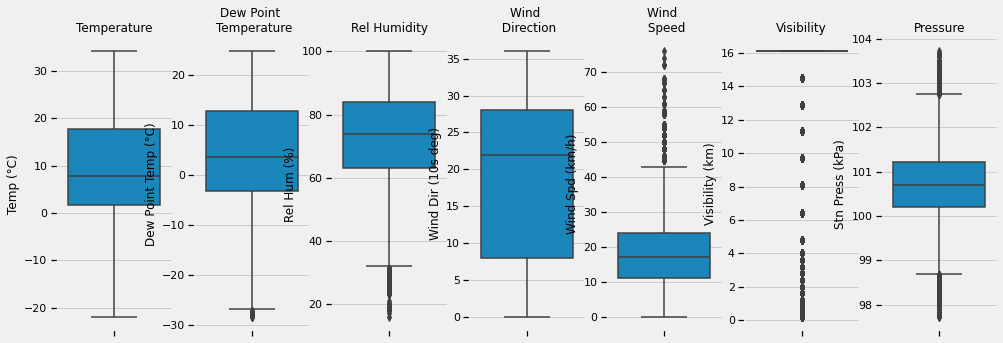

In [20]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1,7,figsize = (15,5))

sns.boxplot(y = 'Temp (°C)', data = df_weather_data, ax = ax1)
ax1.set_title('Temperature')

sns.boxplot(y = 'Dew Point Temp (°C)', data = df_weather_data, ax = ax2)
ax2.set_title('Dew Point \n Temperature')

sns.boxplot(y = 'Rel Hum (%)', data = df_weather_data, ax = ax3)
ax3.set_title('Rel Humidity')

sns.boxplot(y = 'Wind Dir (10s deg)', data = df_weather_data, ax = ax4)
ax4.set_title('Wind \n Direction')

sns.boxplot(y = 'Wind Spd (km/h)', data = df_weather_data, ax = ax5)
ax5.set_title('Wind \n Speed')

sns.boxplot(y = 'Visibility (km)', data = df_weather_data, ax = ax6)
ax6.set_title('Visibility')

sns.boxplot(y = 'Stn Press (kPa)', data = df_weather_data, ax = ax7)
ax7.set_title('Pressure')

fig.show()

In [21]:
print('{:.2f}% of the weather records indicate a visibility 16.1 km, while {:.2f}% of the days are have clear skies'
      .format((df_weather_data['Visibility (km)'] == 16.1).sum()/df_weather_data.shape[0]*100
              , (df_weather_data['Weather'] == 'clear_day').sum()/df_weather_data.shape[0]*100))

87.56% of the weather records indicate a visibility 16.1 km, while 84.19% of the days are have clear skies


### Due to the relationship between the Visibility and clear days it is plausable that a high number of records indicate 16.1 km of visibility

In [22]:
#export the data frame
df_weather_data.to_csv('cleaned_weather_data_set.csv')

# 2. Bike Share Trip Data

In [23]:
# Create a list of file names for bike share trips data
trips_filenames = [filename for filename in os.listdir() if 'bike_share' in filename]

# Create a dictionary where key:value pairs correspond to 
# the file name and DataFrame respectively
trips_data = {filename: pd.read_csv(filename) for filename in trips_filenames}

# Now lets print out the column names for the first month of each year
print('2017\n{}\n'.format(trips_data['bike_share_2017-1.csv'].columns.tolist()))
print('2018\n{}\n'.format(trips_data['bike_share_2018-1.csv'].columns.tolist()))
print('2019\n{}\n'.format(trips_data['bike_share_2019-1.csv'].columns.tolist()))
print('2020\n{}\n'.format(trips_data['bike_share_2020-1.csv'].columns.tolist()))

2017
['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds', 'from_station_id', 'from_station_name', 'to_station_id', 'to_station_name', 'user_type']

2018
['trip_id', 'trip_duration_seconds', 'from_station_id', 'trip_start_time', 'from_station_name', 'trip_stop_time', 'to_station_id', 'to_station_name', 'user_type']

2019
['Trip Id', 'Subscription Id', 'Trip  Duration', 'Start Station Id', 'Start Time', 'Start Station Name', 'End Station Id', 'End Time', 'End Station Name', 'Bike Id', 'User Type']

2020
['Trip Id', 'Subscription Id', 'Trip  Duration', 'Start Station Id', 'Start Time', 'Start Station Name', 'End Station Id', 'End Time', 'End Station Name', 'Bike Id', 'User Type']



In [93]:
# Build two data frames to be merged later
df_trips_data = pd.DataFrame()

for file in trips_filenames:
    if '2017' in file:
        df_trips_data= pd.concat([df_trips_data,pd.read_csv(file)])

#correct the order of the columns from 2017 to match 2018
df_trips_data = df_trips_data[trips_data['bike_share_2018-1.csv'].columns.tolist()]

#add the 2018 files to the list
for file in trips_filenames:
    if '2018' in file:
        df_trips_data= pd.concat([df_trips_data,pd.read_csv(file)])

#correct column names and add additional columns for Bike ID and subscription ID
df_trips_data['Bike Id'] = np.zeros(df_trips_data.shape[0])
df_trips_data['Subscription Id'] = np.zeros(df_trips_data.shape[0])
#correct the order of the columns to match the 2019/2020 data
cols = df_trips_data.columns.tolist()
new_order = [0,10,1,2,3,4,6,5,7,9,8]
cols = [cols[i] for i in new_order]

#reorder columns of the Data frame
df_trips_data = df_trips_data[cols]

#rename column headers of the data frame
df_trips_data.columns = trips_data['bike_share_2019-1.csv'].columns.tolist()

#complete the reading of all the files to the dataframe
for file in trips_filenames:
    if ('2019' in file) |('2020' in file) :
        df_trips_data  = pd.concat([df_trips_data ,pd.read_csv(file)])

# Let's remove double spaces from the column names
df_trips_data.columns = ['_'.join(col.split()) for col in df_trips_data.columns]              

#view data frame   
df_trips_data.head()

,Trip_Id,Subscription_Id,Trip_Duration,Start_Station_Id,Start_Time,Start_Station_Name,End_Station_Id,End_Time,End_Station_Name,Bike_Id,User_Type
0,712441,0.0,274,7006.0,2017-01-01 05:03 (UTC),Bay St / College St (East Side),7021.0,2017-01-01 05:08 (UTC),Bay St / Albert St,0.0,Member
1,712442,0.0,538,7046.0,2017-01-01 05:03 (UTC),Niagara St / Richmond St W,7147.0,2017-01-01 05:12 (UTC),King St W / Fraser Ave,0.0,Member
2,712443,0.0,992,7048.0,2017-01-01 05:05 (UTC),Front St / Yonge St (Hockey Hall of Fame),7089.0,2017-01-01 05:22 (UTC),Church St / Wood St,0.0,Member
3,712444,0.0,1005,7177.0,2017-01-01 05:09 (UTC),East Liberty St / Pirandello St,7202.0,2017-01-01 05:26 (UTC),Queen St W / York St (City Hall),0.0,Member
4,712445,0.0,645,7203.0,2017-01-01 05:14 (UTC),Bathurst St / Queens Quay W,7010.0,2017-01-01 05:25 (UTC),King St W / Spadina Ave,0.0,Member


In [48]:
print("{:.1f} % of the trip Id's are unique".format(len(df_trips_data['Trip_Id'].unique())/df_trips_data.shape[0]*100))
df_trips_data.shape

100.0 % of the trip Id's are unique


(8467545, 11)

In [29]:
df_trips_data.isnull().sum()/df_trips_data.shape[0]*100

Trip_Id                0.000000
Subscription_Id        0.000000
Trip_Duration          0.000000
Start_Station_Id      12.127399
Start_Time             0.000000
Start_Station_Name     0.001937
End_Station_Id        12.142351
End_Time               0.000012
End_Station_Name       0.016640
Bike_Id                0.000000
User_Type              0.000000
dtype: float64

In [97]:
df_trips_data = df_trips_data[df_trips_data['Start_Station_Name'].notnull()]
df_trips_data = df_trips_data[df_trips_data['End_Station_Name'].notnull()]

In [99]:
df_trips_data.isnull().sum()/df_trips_data.shape[0]*100

Trip_Id                0.000000
Subscription_Id        0.000000
Trip_Duration          0.000000
Start_Station_Id      12.129631
Start_Time             0.000000
Start_Station_Name     0.000000
End_Station_Id        12.129631
End_Time               0.000000
End_Station_Name       0.000000
Bike_Id                0.000000
User_Type              0.000000
dtype: float64

In [ ]:
# look at Station Id' with Null Values
#df_missing_stat_ID = df_trips_data[df_trips_data['Start_Station_Id'].isnull()]

num_records = df_missing_stat_ID.shape[0]
print(num_records)
for indx in range (num_records):
    
    stat_id =stations[stations['Station Name'].str.contains(df_missing_stat_ID.iloc[indx,5])]['Station Id'].to_numpy()
    if 0<len(stat_id) <2:
        df_missing_stat_ID.loc[indx,'Start_Station_Id'] = stat_id[0]

df_missing_stat_ID.head()

1026893


## Station ID's
A number of the station ID's are missing, these could be substituded using the station name

# 3. Station Data

In [30]:
stations = pd.read_csv('bikeshare_stations.csv')
stations.head()

,Station Id,Station Name,lat,lon,capacity
0,7000,Fort York Blvd / Capreol Ct,43.639832,-79.395954,35
1,7001,Lower Jarvis St / The Esplanade,43.647830,-79.370698,15
2,7002,St. George St / Bloor St W,43.667333,-79.399429,19
3,7003,Madison Ave / Bloor St W,43.667158,-79.402761,15
4,7004,University Ave / Elm St,43.656518,-79.389099,11


In [76]:
stations.isnull().sum()/stations.shape[0]*100

Station Id      0.0
Station Name    0.0
lat             0.0
lon             0.0
capacity        0.0
dtype: float64

To fix the missing station ID's merge the stations dataframe and the 

In [69]:
#merge on start station name to fill in data
df_trips_data = pd.merge(df_trips_data, stations, left_on = 'Start_Station_Name', right_on = 'Station Name', how = 'outer')


#clean up the station ID information
df_trips_data['Start_Station_Id'] = df_trips_data['Station Id']
#rename lat & lon to start station lat and long
df_trips_data = df_trips_data.rename(columns ={'lat': 'Start_Station_lat', 'lon': 'Start_Station_lon'})
df_trips_data.drop(columns = ['Station Id', 'Station Name', 'capacity'], inplace = True)

#merge on end station to fill in missing data
df_trips_data = pd.merge(df_trips_data, stations, left_on = 'End_Station_Name', right_on = 'Station Name', how = 'outer')
#clean up the station ID information
df_trips_data['End_Station_Id'] = df_trips_data['Station Id']
#rename lat & lon to start station lat and long
df_trips_data = df_trips_data.rename(columns ={'lat': 'End_Station_lat', 'lon': 'End_Station_lon'})
df_trips_data.drop(columns = ['Station Id', 'Station Name', 'capacity'], inplace = True)


df_trips_data.head()

,Trip_Id,Subscription_Id,Trip_Duration,Start_Station_Id,Start_Time,Start_Station_Name,End_Station_Id,End_Time,End_Station_Name,Bike_Id,User_Type,Start_Station_lat,Start_Station_lon,End_Station_lat,End_Station_lon
0,712441.0,0.0,274.0,7006.0,2017-01-01 05:03 (UTC),Bay St / College St (East Side),7021.0,2017-01-01 05:08 (UTC),Bay St / Albert St,0.0,Member,43.660439,-79.385525,43.653264,-79.382458
1,717862.0,0.0,252.0,7006.0,2017-01-05 23:06 (UTC),Bay St / College St (East Side),7021.0,2017-01-05 23:11 (UTC),Bay St / Albert St,0.0,Member,43.660439,-79.385525,43.653264,-79.382458
2,719500.0,0.0,241.0,7006.0,2017-01-06 23:46 (UTC),Bay St / College St (East Side),7021.0,2017-01-06 23:50 (UTC),Bay St / Albert St,0.0,Member,43.660439,-79.385525,43.653264,-79.382458
3,722310.0,0.0,262.0,7006.0,2017-01-10 00:17 (UTC),Bay St / College St (East Side),7021.0,2017-01-10 00:21 (UTC),Bay St / Albert St,0.0,Member,43.660439,-79.385525,43.653264,-79.382458
4,723078.0,0.0,285.0,7006.0,2017-01-10 22:37 (UTC),Bay St / College St (East Side),7021.0,2017-01-10 22:42 (UTC),Bay St / Albert St,0.0,Member,43.660439,-79.385525,43.653264,-79.382458


combine the information from the stations DF into the Trips DF to add features such as average speed, distance travelled and correct the missing station ID's


In [70]:
df_trips_data.isnull().sum()/df_trips_data.shape[0]*100

Trip_Id                0.002267
Subscription_Id        0.002267
Trip_Duration          0.002267
Start_Station_Id      10.580867
Start_Time             0.002267
Start_Station_Name     0.004204
End_Station_Id        10.423848
End_Time               0.002279
End_Station_Name       0.018907
Bike_Id                0.002267
User_Type              0.002267
Start_Station_lat     10.580867
Start_Station_lon     10.580867
End_Station_lat       10.423848
End_Station_lon       10.423848
dtype: float64

In [71]:
df_trips_data[df_trips_data['Start_Station_lat'].isnull()]

,Trip_Id,Subscription_Id,Trip_Duration,Start_Station_Id,Start_Time,Start_Station_Name,End_Station_Id,End_Time,End_Station_Name,Bike_Id,User_Type,Start_Station_lat,Start_Station_lon,End_Station_lat,End_Station_lon
1082,764921.0,0.0,980.0,NaN,2017-02-02 23:07 (UTC),Front St / Yonge St (Hockey Hall of Fame),7021.0,2017-02-02 23:24 (UTC),Bay St / Albert St,0.0,Member,NaN,NaN,43.653264,-79.382458
1083,846381.0,0.0,383.0,NaN,2017-03-21 18:59 (UTC),Front St / Yonge St (Hockey Hall of Fame),7021.0,2017-03-21 19:05 (UTC),Bay St / Albert St,0.0,Member,NaN,NaN,43.653264,-79.382458
1084,874219.0,0.0,290.0,NaN,2017-04-03 18:32 (UTC),Front St / Yonge St (Hockey Hall of Fame),7021.0,2017-04-03 18:37 (UTC),Bay St / Albert St,0.0,Member,NaN,NaN,43.653264,-79.382458
1085,874721.0,0.0,605.0,NaN,2017-04-03 21:47 (UTC),Front St / Yonge St (Hockey Hall of Fame),7021.0,2017-04-03 21:57 (UTC),Bay St / Albert St,0.0,Member,NaN,NaN,43.653264,-79.382458
1086,900397.0,0.0,316.0,NaN,2017-04-13 01:18 (UTC),Front St / Yonge St (Hockey Hall of Fame),7021.0,2017-04-13 01:23 (UTC),Bay St / Albert St,0.0,Member,NaN,NaN,43.653264,-79.382458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8467732,NaN,NaN,NaN,NaN,NaN,NaN,7662.0,NaN,NaN,NaN,NaN,NaN,NaN,43.639311,-79.440814
8467733,NaN,NaN,NaN,NaN,NaN,NaN,7663.0,NaN,NaN,NaN,NaN,NaN,NaN,43.718039,-79.371914
8467734,NaN,NaN,NaN,NaN,NaN,NaN,7664.0,NaN,NaN,NaN,NaN,NaN,NaN,43.722680,-79.376440
8467735,NaN,NaN,NaN,NaN,NaN,NaN,7665.0,NaN,NaN,NaN,NaN,NaN,NaN,43.720669,-79.377553


In [86]:
stations[stations['Station Name'].str.contains('Hockey Hall of Fame')]

,Station Id,Station Name,lat,lon,capacity
48,7048,Front St W / Yonge St (Hockey Hall of Fame),43.646144,-79.377962,47


### In stations Data Frame Front St / Yonge St (Hockey Hall of Fame) is Front St W / Yonge St (Hockey Hall of Fame)

Deal with cases on a case by case bases and correct

In [92]:
for i in range(df_trips_data.shape[0]):
        if df_trips_data.loc[i,'Start_Station_Name'] == 'Front St/Yonge St (Hockey Hall of Fame)':
            df_trips_data.loc[i,'Start_Station_Id'] = stations[stations['Station Name'] == 'Front St W/Yonge St (Hockey Hall of Fame)']['Station Id']
            


ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types

In [90]:
df_trips_data[df_trips_data['Start_Station_lat'].isnull()]

,Trip_Id,Subscription_Id,Trip_Duration,Start_Station_Id,Start_Time,Start_Station_Name,End_Station_Id,End_Time,End_Station_Name,Bike_Id,User_Type,Start_Station_lat,Start_Station_lon,End_Station_lat,End_Station_lon
1082,764921.0,0.0,980.0,NaN,2017-02-02 23:07 (UTC),Front St / Yonge St (Hockey Hall of Fame),7021.0,2017-02-02 23:24 (UTC),Bay St / Albert St,0.0,Member,NaN,NaN,43.653264,-79.382458
1083,846381.0,0.0,383.0,NaN,2017-03-21 18:59 (UTC),Front St / Yonge St (Hockey Hall of Fame),7021.0,2017-03-21 19:05 (UTC),Bay St / Albert St,0.0,Member,NaN,NaN,43.653264,-79.382458
1084,874219.0,0.0,290.0,NaN,2017-04-03 18:32 (UTC),Front St / Yonge St (Hockey Hall of Fame),7021.0,2017-04-03 18:37 (UTC),Bay St / Albert St,0.0,Member,NaN,NaN,43.653264,-79.382458
1085,874721.0,0.0,605.0,NaN,2017-04-03 21:47 (UTC),Front St / Yonge St (Hockey Hall of Fame),7021.0,2017-04-03 21:57 (UTC),Bay St / Albert St,0.0,Member,NaN,NaN,43.653264,-79.382458
1086,900397.0,0.0,316.0,NaN,2017-04-13 01:18 (UTC),Front St / Yonge St (Hockey Hall of Fame),7021.0,2017-04-13 01:23 (UTC),Bay St / Albert St,0.0,Member,NaN,NaN,43.653264,-79.382458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8467732,NaN,NaN,NaN,NaN,NaN,NaN,7662.0,NaN,NaN,NaN,NaN,NaN,NaN,43.639311,-79.440814
8467733,NaN,NaN,NaN,NaN,NaN,NaN,7663.0,NaN,NaN,NaN,NaN,NaN,NaN,43.718039,-79.371914
8467734,NaN,NaN,NaN,NaN,NaN,NaN,7664.0,NaN,NaN,NaN,NaN,NaN,NaN,43.722680,-79.376440
8467735,NaN,NaN,NaN,NaN,NaN,NaN,7665.0,NaN,NaN,NaN,NaN,NaN,NaN,43.720669,-79.377553
